# Final notebook of the neighborhood pricing Kaggle contest

In [1]:
# Import my tools
import numpy as np
import pandas as pd
import kaggle
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('clean.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
#df.fillna(0, inplace=True)
df = df.convert_dtypes()

In [3]:
# a quick thing to only display the missing entries
def Missing (train):
    Missing={n:train[n].isna() for n in train.keys()}
    Missing_data=pd.DataFrame(Missing).sum()
    results=Missing_data[Missing_data>0]
    return results

In [4]:
Missing(df)

LotFrontage      257
Alley           1361
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      686
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1445
Fence           1171
MiscFeature     1399
dtype: int64

In [5]:
categorical_columns = df.select_dtypes(['string','object']).columns
numerical_columns = df.select_dtypes(['Int64','float64']).columns

X=df.drop('SalePrice',axis=1)
y=df[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
numerical_pipe = Pipeline([("imputer", SimpleImputer(strategy="mean"))])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestRegressor(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

ValueError: A given column is not a column of the dataframe

In [7]:
ohe = rf.named_steps["preprocess"].named_transformers_["cat"]
feature_names = ohe.get_feature_names_out(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = rf.named_steps["classifier"].feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [8]:
Missing(df)

LotFrontage      257
Alley           1361
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      686
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1445
Fence           1171
MiscFeature     1399
dtype: int64

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df2 = df.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')


#### I was currious what would happen if I didn't drop all these NaN Columns

In [10]:
X2=df2.drop('SalePrice',axis=1)
y2=df2[['SalePrice']]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.25, random_state=7) # random_state used for reproducibility
print(X2_train.shape, X2_test.shape)
print(y2_train.shape,y2_test.shape)

(1089, 81) (363, 81)
(1089, 1) (363, 1)


Score:  0.9362980213863079


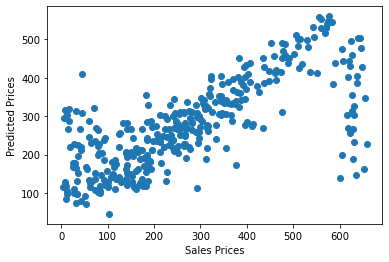

In [11]:
clf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
model_res = clf.fit(X2_train, y2_train)
y_pred = model_res.predict(X2_test)
score = model_res.score(X2_train,y2_train)
plt.scatter(y2_test,y_pred)
plt.xlabel('Sales Prices')
plt.ylabel('Predicted Prices')
print('Score: ',score)

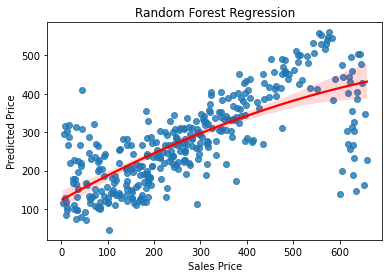

In [12]:
rf_plot=sns.regplot(y2_test,y_pred,line_kws={"color": "red"}, order=2)
rf_plot=plt.title('Random Forest Regression')
rf_plot=plt.xlabel('Sales Price')
rf_plot=plt.ylabel('Predicted Price')
plt.show()

<font color='red'> Seems like it's less accurate </font>

### Lets make a pipeline which can manage the data for the final submission to Kagle

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


In [14]:
# Lets make two functions that will do the data cleaning for us.
# If I wanted to I could make this an OOP  Haven't made on in a while.
def nan_remover(df):
    nan_values=df.isna()
    nan_columns=nan_values.any()
    columns_with_nan=df.columns[nan_columns].tolist()
    return df.drop(columns_with_nan, axis=1)

def le_columns(df):
    le=LabelEncoder()
    df3=df.copy()
    cat_columns=df.select_dtypes(['string','object']).columns
    for n in cat_columns:
        le.fit(df3[n])
        df3[n]=le.transform(df3[n])
    return df3


In [15]:
test=pd.read_csv('test.csv')
nf=pd.read_csv('Neighborhood_Means.csv')

In [16]:
# merge the neighborhood prices to the DF so we can 
df1=test.merge(nf, left_on=['Neighborhood','YrSold'], right_on=['Neighborhood','YrSold'])

In [17]:
print ('test shape ',test.shape, '\nDF1 Shape ',df1.shape)

test shape  (1459, 80) 
DF1 Shape  (1459, 81)


In [18]:
# I lost too many columns in the merge
Missing(test)

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

**This data has a lot more NaN issues than did the previous data!**

In [19]:
test1=test.copy()
for n in test.columns:
    if test1[n].isna().sum() <16:
        test1[n].fillna(test1[n].value_counts().idxmax(), inplace=True)

In [20]:
Missing(test1)

LotFrontage      227
Alley           1352
MasVnrType        16
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
dtype: int64

In [21]:
test1[['MasVnrType','MasVnrArea']][test1['MasVnrType'].isna()]

,MasVnrType,MasVnrArea
231,NaN,0.0
246,NaN,0.0
422,NaN,0.0
532,NaN,0.0
544,NaN,0.0
581,NaN,0.0
851,NaN,0.0
865,NaN,0.0
880,NaN,0.0
889,NaN,0.0


In [22]:
# am I allowed to drop any rows?

In [23]:
nan_columns=list(Missing(df).index)

In [24]:
columns_with_nan=test1[nan_columns].columns.tolist()

In [25]:
test1.drop(columns_with_nan, axis=1, inplace=True)

In [26]:
Missing(test1)

MasVnrType    16
dtype: int64

In [27]:
df1=test1.merge(nf, left_on=['Neighborhood','YrSold'], right_on=['Neighborhood','YrSold'])

In [28]:
df1

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,NeighborhoodPrice
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,120,0,0,6,2010,WD,Normal,153665.909091
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,12500,6,2010,WD,Normal,153665.909091
2,1470,20,RL,8400,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,4,2010,WD,Normal,153665.909091
3,1471,120,RH,5858,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,6,2010,WD,Normal,153665.909091
4,1510,20,RL,9600,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2010,WD,Normal,153665.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2911,160,RM,1484,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2006,WD,Normal,123466.666667
1455,2913,160,RM,1533,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,12,2006,WD,Abnorml,123466.666667
1456,2914,160,RM,1526,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,123466.666667
1457,2915,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,123466.666667


In [29]:
df1.shape

(1459, 65)

In [30]:
for n in df1.columns:
    if df1[n].isna().sum() <=16:
        df1[n].fillna(df1[n].value_counts().idxmax(), inplace=True)

In [31]:
df1=le_columns(df1)

In [32]:
# make the training data
df3=df.copy()
df3=nan_remover(df3)
df3=le_columns(df3)

In [33]:
X=df3.drop('SalePrice',axis=1)
y=df3[['SalePrice']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=7) # random_state used for reproducibility
clf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
score = model_res.score(X_train,y_train)

Final_test=df1

y_pred = model_res.predict(Final_test)

In [34]:
print('Train Shape ', df3.shape, '\nTest Shape ',df1.shape)

Train Shape  (1452, 66) 
Test Shape  (1459, 65)


In [35]:
final=[df1['Id'],y_pred]

In [36]:
final=pd.DataFrame(final).T

In [37]:
final.rename(columns={'Unnamed 0':'SalePrice'}, inplace=True)

In [59]:
final.to_csv('Final_Prediction.csv', index=False)

In [41]:
clf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
score = model_res.score(X_train,y_train)
print('Score: ',score)

Score:  0.9831085618138031


In [54]:
y_test=y_test.astype('float64')
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363 entries, 186 to 1027
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SalePrice  363 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


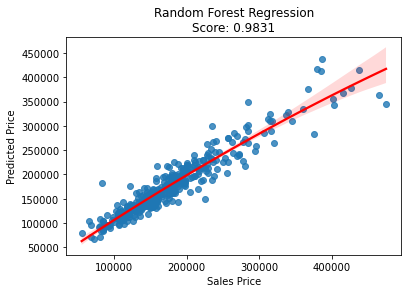

In [56]:
rf_plot=sns.regplot(y_test,y_pred,line_kws={"color": "red"}, order=2)
rf_plot=plt.title('Random Forest Regression\nScore: 0.9831')
rf_plot=plt.xlabel('Sales Price')
rf_plot=plt.ylabel('Predicted Price')
plt.show()

In [40]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
clf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
scores = cross_val_score(clf, X_test, y_test, cv=5)
scores

array([0.86961833, 0.83598363, 0.88580732, 0.85607423, 0.79286586])

In [58]:
rf_plot.figure.savefig('Ranforest.png')